In [1]:
from math import log
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
params = {
    'batch_size': 128, #size of the batches
    'image_size': 32, #size of each image dimension
    'lr': 0.0001, #adam: learning rate
    'b1': 0.5, #adam: decay of first order momentum of gradient
    'b2': 0.999, #adam: decay of first order momentum of gradient
}

In [3]:
transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(params['image_size']),
    transforms.ToTensor(),
#     transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [4]:
trainset = datasets.MNIST(root='./data', train='train',
                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], pin_memory=True,
                                          shuffle=True)
testset = datasets.MNIST(root='./data', train=False,
                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=params['batch_size'], pin_memory=True,
                                         shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

    4     0     0     5


In [6]:
def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Basic architecture implemented in the PyTorch tutorial
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size=[3,3], padding=1, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=[3,3], padding=1, stride=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 8 * 8, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.max_pooling = nn.MaxPool2d(kernel_size=(2,2), stride=2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.max_pooling(F.relu(self.conv1(x)))
        # If the size is a square you can only specify a single number
        x = self.max_pooling(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [8]:
# Neural network with cross entropy loss
net = Net()
net.apply(weights_init)
print("Successfully initialized neural network...")

Successfully initialized neural network...


In [12]:
# loss fucntion of neural entropic estimation for classification
# loss = E(f(x*,x,y)) - E[ln(1/|y|) * sum_y(e^f(x*,x,y))]

def loss_func(x_output, y, num_classes = 10):
    # TODO: Check gradient function
    f_label = torch.zeros([128])
    for idx, class_lbl in enumerate(y):
        f_label[idx] = x_output[idx][class_lbl]
    mean_f = f_label.mean()  # E(f(x*,x,y))
    mean_class = torch.log(1 / num_classes * torch.sum(torch.exp(x_output), 1)).mean()
    loss = -(mean_f - mean_class)
    return loss

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=params['lr'], betas=(params['b1'], params['b2']))

In [14]:
print("Training neural network with neural entropic loss...")
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

Training neural network with neural entropic loss...
[1,   100] loss: 0.001
[1,   200] loss: -0.015
[1,   300] loss: -0.332
[1,   400] loss: -0.697
[2,   100] loss: -0.856
[2,   200] loss: -0.884
[2,   300] loss: -0.913
[2,   400] loss: -0.927
[3,   100] loss: -0.953
[3,   200] loss: -0.962
[3,   300] loss: -0.962
[3,   400] loss: -0.965
[4,   100] loss: -0.983
[4,   200] loss: -0.992
[4,   300] loss: -0.995
[4,   400] loss: -0.994
Finished Training


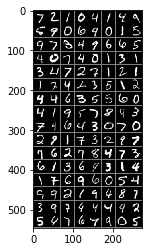

GroundTruth:      7     2     1     0


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
outputs = net(images)

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:      7     2     1     0


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels).item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 91 %


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 97 %
Accuracy of     1 : 96 %
Accuracy of     2 : 92 %
Accuracy of     3 : 85 %
Accuracy of     4 : 91 %
Accuracy of     5 : 86 %
Accuracy of     6 : 92 %
Accuracy of     7 : 90 %
Accuracy of     8 : 96 %
Accuracy of     9 : 94 %
